# Задача

# Введение
В Контуре мы много работаем с документами: арбитражные иски, госзакупки, исполнительные производства. В данном задании мы предлагаем вам сделать модель, которая поможет отделу госзакупок извлекать 
нужный кусок текста из документа для того, чтобы сформировать анкету заявки. То, какой именно фрагмент текста нужно извлечь, зависит от пункта анкеты, соответствующего документу.
Всего в каждом документе, с которыми вы будет работать, есть 1 из 2-х пунктов анкеты, по которым необходимо извлекать кусочки из текста:
- обеспечение исполнения контракта
- обеспечение гарантийных обязательств

Соответственно, ваша модель, принимая на вход `текст документа` и `наименование одного из двух пунктов`, должна возвращать `соответствующий кусочек текста из текста документа`.

# Данные

### train.json 
Данные для обучения в формате json имеют следующие поля:
- `id`: int - id документа
-  `text`: str - текст документа, в котором может содержаться фрагмент текста, соответствующий пункту анкеты из поля `label`
- `label`: str - название пункта анкеты. Может принимать одно из двух значений: `обеспечение исполнения контракта` или `обеспечение гарантийных обязательств`
- `extracted_part`: dict следующего формата:
    ```
    {
        'text': [фрагмент текста из поля `text`, соответствующий пункту анкеты], 
        'answer_start': [индекс символа начала фрагмента текста в тексте документа],
        'answer_end': [индекс символа конца фрагмента текста в тексте документа]
    }
   ```
  
### test.json

Для демонстрации работы модели используйте данные из файла `test.json`. В нем есть все те же поля, что и в файле `train.json`, кроме поля `extracted_part` - именно его вам и нужно будет добавить,
для того, чтобы мы смогли оценить качество вашей модели.

# Тестовое задание

Для выполнения тестового задания требуется разработать модель, которая будет способна по паре `текст документа` и `пункт анкеты` извлекать из текста документа нужный фрагмент текста. 
Обучив модель, добавьте в файл `test.json` поле `extracted_part` в том же формате, что и в файле `train.json`. Новый файл назовите `predictions.json`

**Подсказка**: изучив данные, вы можете заметить, что у части наблюдений отсутствует фрагмент текста к извлечению (пустая строка внутри поля `extracted_part` с `answer_start` и
`answer_end` равными нулю). Это означает, что в тексте документа нет нужного фрагмента текста, соответствующего пункту анкеты. Учтите это в обучении вашей модели и при формировании
файла с ответами.

# Критерии оценки
1. Для оценки финального решения будет использоваться метрика `Accuracy`: доля наблюдений, в которых извлеченный моделью фрагмент текста полностью соответствует фактически
   требуемому фрагменту.
2. Чистота кода, оформление и понятность исследования.

# Требования к решению
В качестве решения мы ожидаем zip-архив со всеми *.py и *.ipynb файлами в папке solution и файлом `predictions.json` в корне. Формат имени zip-архива: LastName_FirstName.zip (пример Ivanov_Ivan.zip).
Файл `predictions.json` должен включать в себя колонки `id`, `text`, `label`, содержащие те же данные, что и исходный файл `test.json`, а также колонку `extracted_part` в том же
формате, что и в файле `train.json`
Разметка тестового набора данных и включение его в обучение/валидацию запрещены.

В папке solution должно быть отражено исследование и весь код, необходимый для воспроизведения исследования.

Успехов!

## Генерация датасетов

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import json
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from tensorflow import keras
import tensorflow as tf 
import tensorflow as tf 
from keras import models
from keras import layers
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import spacy
import random
from spacy.lang.ru import Russian
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import zscore

2023-04-18 15:34:59.148374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 15:34:59.271294: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-18 15:34:59.271313: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-18 15:34:59.935434: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# EDA

In [2]:
train_df = pd.read_json('dataset/train.json', orient='records')

In [3]:
train_df

id                                               text  \
0     809436509  Извещение о проведении открытого конкурса в эл...   
1     854885310  ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...   
2       4382157  Извещение о проведении электронного аукциона д...   
3     184555082  Извещение о проведении электронного аукциона д...   
4     211645258  Извещение о проведении электронного аукциона д...   
...         ...                                                ...   
1794  938335285  «УТВЕРЖДАЮ» Директор МУП "ПКП и ОРТ" _________...   
1795  214609521  ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯ...   
1796   94811748  ДОГОВОР ПОДРЯДА № _____ «___»___________20____...   
1797  903507299  ДОКУМЕНТАЦИЯ О ЗАКУПКЕ ЗАПРОС ПРЕДЛОЖЕНИЙ В ЭЛ...   
1798  926039184  Государственная корпорацИя по атомной энергии ...   

                                     label  \
0         обеспечение исполнения контракта   
1         обеспечение исполнения контракта   
2         обеспечение исполнения контракта   
3         обеспечение исполнения контракта   
4         обеспечение исполнения контракта   
...                                    ...   
1794  обеспечение гарантийных обязательств   
1795  обеспечение гарантийных обязательств   
1796  обеспечение гарантийных обязательств   
1797  обеспечение гарантийных обязательств   
1798  обеспечение гарантийных обязательств   

                                         extracted_part  
0     {'text': ['Размер обеспечения исполнения контр...  
1     {'text': ['Поставщик должен предоставить обесп...  
2     {'text': ['Размер обеспечения исполнения контр...  
3     {'text': ['Размер обеспечения исполнения контр...  
4     {'text': ['Размер обеспечения исполнения контр...  
...                                                 ...  
1794  {'text': ['Заказчиком установлено требование о...  
1795  {'text': [''], 'answer_start': [0], 'answer_en...  
1796  {'text': [''], 'answer_start': [0], 'answer_en...  
1797  {'text': [''], 'answer_start': [0], 'answer_en...  
1798  {'text': [''], 'answer_start': [0], 'answer_en...  

[1799 rows x 4 columns]

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1799 non-null   int64 
 1   text            1799 non-null   object
 2   label           1799 non-null   object
 3   extracted_part  1799 non-null   object
dtypes: int64(1), object(3)
memory usage: 56.3+ KB


In [5]:
train_df.isna().sum()

id                0
text              0
label             0
extracted_part    0
dtype: int64

In [6]:
train_df[['text',	'label'	]].duplicated().sum()

0

In [71]:

# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

In [8]:
print(train_df['extracted_part'].head(1).astype( str ))

0    {'text': ['Размер обеспечения исполнения контракта 6593.25 Российский рубль'], 'answer_start': [1279], 'answer_end': [1343]}
Name: extracted_part, dtype: object


In [9]:
obj = dict(train_df['extracted_part'].values[0])
print(obj['text'], obj['answer_start'],obj['answer_end'])

['Размер обеспечения исполнения контракта 6593.25 Российский рубль'] [1279] [1343]


In [10]:
print(train_df['text'].values[0])

Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты счета в соответствии с п.16 ч. 1 

In [11]:
result = [_.start() for _ in re.finditer('Размер обеспечения исполнения контракта 6593.25 Российский рубль', train_df['text'].values[0])] 
print(result[0])
print(result[0]+len('Размер обеспечения исполнения контракта 6593.25 Российский рубль'))



1279
1343


обеспечение исполнения контракта        0.549194
обеспечение гарантийных обязательств    0.450806
Name: label, dtype: float64


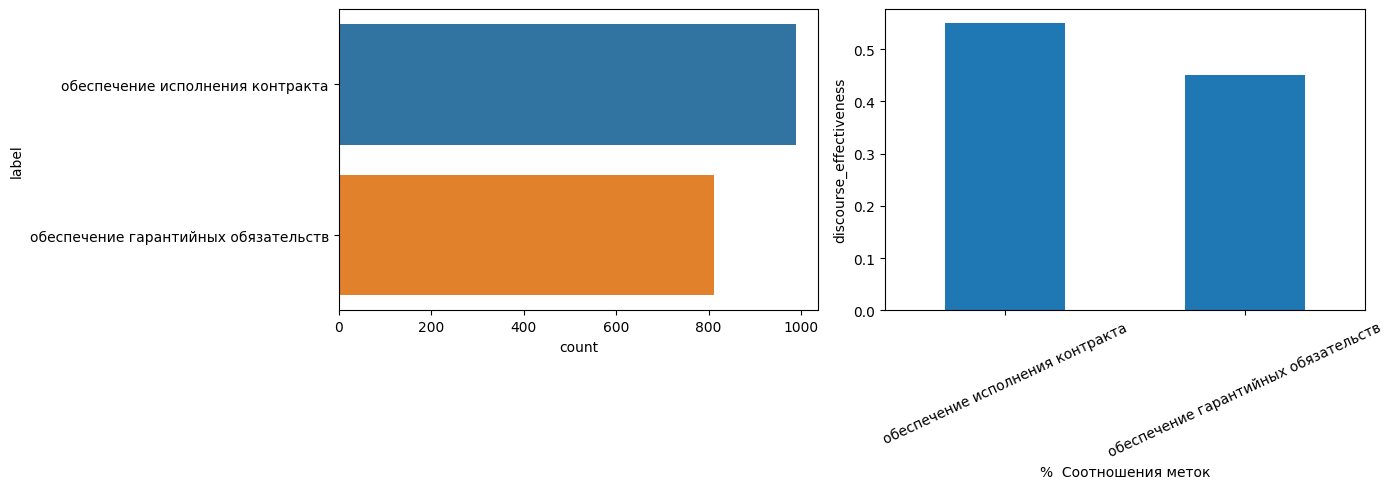

In [12]:
stats_target = train_df['label'].value_counts(normalize=True)
print(stats_target)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.countplot(data=train_df,y='label')
plt.subplot(1,2,2)
stats_target.plot.bar(rot=25)
plt.ylabel('discourse_effectiveness')
plt.xlabel('%  Соотношения меток')
plt.tight_layout()
plt.show()

In [13]:
def length_text(text):
    return len(text.split())

train_df['len_text'] = train_df['text'].apply(length_text)

In [14]:
train_df

id  \
0     809436509   
1     854885310   
2       4382157   
3     184555082   
4     211645258   
...         ...   
1794  938335285   
1795  214609521   
1796   94811748   
1797  903507299   
1798  926039184   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              text  \
0                                                               Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты счета в соответствии с п.16 ч. 1 ст. 42 Закона № 44-ФЗ "Номер расчётного счёта" 00000000000

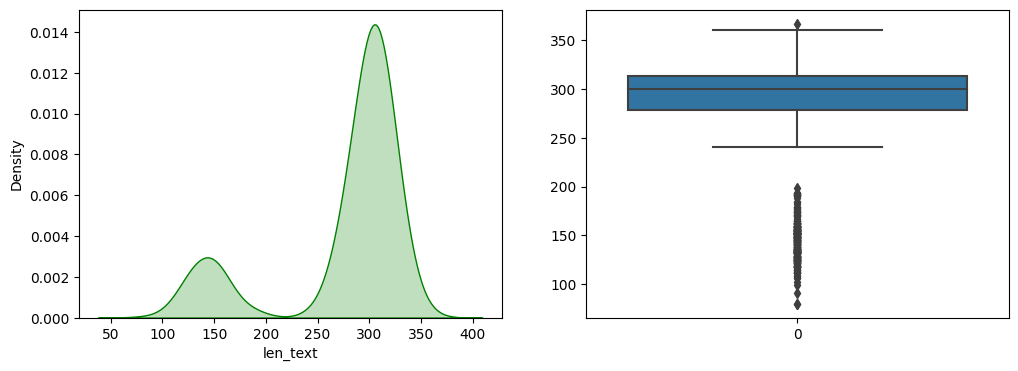

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.kdeplot(train_df['len_text'],color='g',shade=True)
plt.subplot(1,2,2)
sns.boxplot(train_df['len_text'])
plt.show()

In [16]:
y_outliers = train_df[abs(zscore(train_df['len_text'])) >= 3 ]
y_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 868 to 1748
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2 non-null      int64 
 1   text            2 non-null      object
 2   label           2 non-null      object
 3   extracted_part  2 non-null      object
 4   len_text        2 non-null      int64 
dtypes: int64(2), object(3)
memory usage: 96.0+ bytes


In [17]:
y_outliers

id  \
868   218092753   
1748  540120178   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text  \
868   1 УТВЕРЖДАЮ Заместитель генерального директора по общим вопросам ООО «Нововоронежская АЭС- Авто» _______________________ С.В. Козлов «____»________________ 2022 ЗАКУПОЧНАЯ ДОКУМЕНТАЦИЯ открытый одноэтапный запрос предложений в электронной форме без предварительного квалификационного отбора на право заключения договора на Поставку бензина и дизельного топлива на 2022 – 2023 г.г. ТОМ 1 «ОБЩАЯ И КОММЕРЧЕСКАЯ ЧАСТИ» 2022 2 СОДЕРЖАНИЕ Оглавление ЗАКУПОЧНАЯ ДОКУМЕНТАЦИЯ .....................................................................................................1 СОДЕРЖАНИЕ .......................................................................................................................................2 1. ИЗВЕЩЕНИЕ О ПРОВЕДЕНИИ ЗАКУПКИ ...............................................................................3 ЧАСТЬ 1 ................................................................................................................................................10 2. ТРЕБОВА ТОМ 2 Техническое задание приведено в виде отдельного файла.   
1748  1 УТВЕРЖДАЮ: Заместитель генерального директора по общим вопросам ООО «Нововоронежская АЭС- Авто» _______________________ С.В. Козлов «____»________________ 2022 ЗАКУПОЧНАЯ ДОКУМЕНТАЦИЯ открытый запрос предложений в электронной форме на право заключения договора на Поставку продуктов питания: молочная продукция г. Билибино. ТОМ 1 «ОБЩАЯ И КОММЕРЧЕСКАЯ ЧАСТИ» 2022 2 СОДЕРЖАНИЕ Оглавление ЗАКУПОЧНАЯ ДОКУМЕНТАЦИЯ .....................................................................................................1 СОДЕРЖАНИЕ .......................................................................................................................................2 1. ИЗВЕЩЕНИЕ О ПРОВЕДЕНИИ ЗАКУПКИ ...............................................................................3 ЧАСТЬ 1 ................................................................................................................................................10 2. ТРЕБОВАНИЯ. ДОКУМЕНТЫ. СОСТАВ ЗАЯВКИ НА УЧАСТИЕ В ЗАКУПКЕ. ... ТОМ 2 Техническое задание приведено в виде отдельного файла.   

                                     label  \
868   обеспечение гарантийных обязательств   
1748  обеспечение гарантийных обязательств   

                                              extracted_part  len_text  
868   {'text': [''], 'answer_start': [0], 'answer_end': [0]}        80  
1748  {'text': [''], 'answer_start': [0], 'answer_end': [0]}        80

# Обнаружены выбросы удалю их из обучающей выборки.

In [18]:
train_df=train_df.query('len_text!=80')

# Обучающий датасет формирование

In [19]:
train_df['text_str'] = train_df.apply(lambda row: ''.join(dict(row['extracted_part'])['text']), axis=1)
train_df['text_start'] = train_df.apply(lambda row: dict(row['extracted_part'])['answer_start'][0], axis=1)
train_df['text_end'] = train_df.apply(lambda row: dict(row['extracted_part'])['answer_end'][0], axis=1)

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1797 entries, 0 to 1798
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1797 non-null   int64 
 1   text            1797 non-null   object
 2   label           1797 non-null   object
 3   extracted_part  1797 non-null   object
 4   len_text        1797 non-null   int64 
 5   text_str        1797 non-null   object
 6   text_start      1797 non-null   int64 
 7   text_end        1797 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 126.4+ KB


In [21]:
train_df

id  \
0     809436509   
1     854885310   
2       4382157   
3     184555082   
4     211645258   
...         ...   
1794  938335285   
1795  214609521   
1796   94811748   
1797  903507299   
1798  926039184   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              text  \
0                                                               Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты счета в соответствии с п.16 ч. 1 ст. 42 Закона № 44-ФЗ "Номер расчётного счёта" 00000000000

In [22]:
train_df['target']=1

In [23]:
train_df['ent']=''
train_df['pre']=0

# EDA для искомых данных


In [24]:
train_df['len_text_str'] = train_df['text_str'].apply(length_text)

len_text_str
0       0.169727
7       0.149694
15      0.091820
5       0.080134
11      0.058431
13      0.041736
16      0.040623
12      0.037284
10      0.037284
14      0.037284
20      0.035058
8       0.028381
17      0.027268
18      0.021703
19      0.021703
21      0.020033
24      0.016138
22      0.016138
9       0.015582
23      0.011686
6       0.008347
26      0.006121
25      0.005008
31      0.004452
30      0.003895
29      0.003339
27      0.002782
28      0.002782
32      0.001669
4       0.001113
35      0.001113
36      0.000556
40      0.000556
39      0.000556

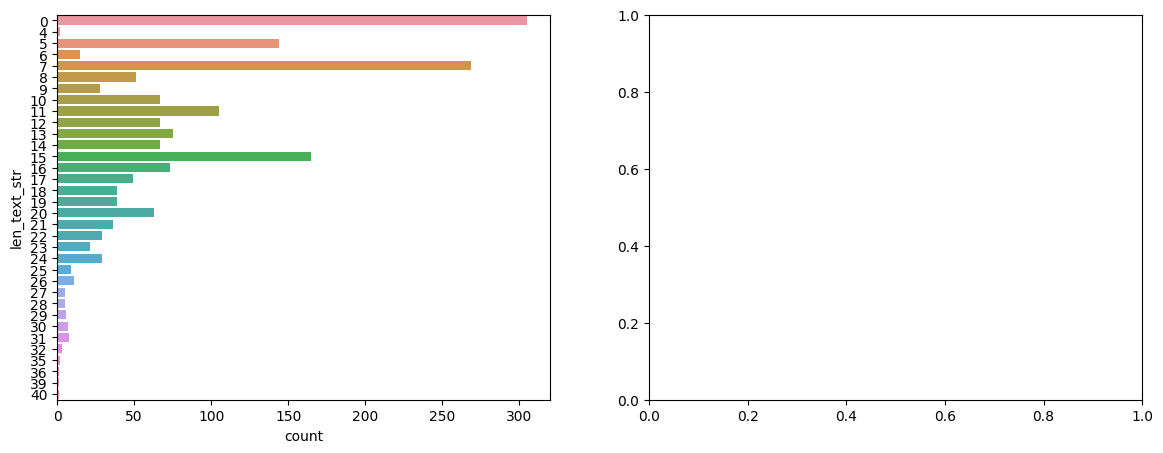

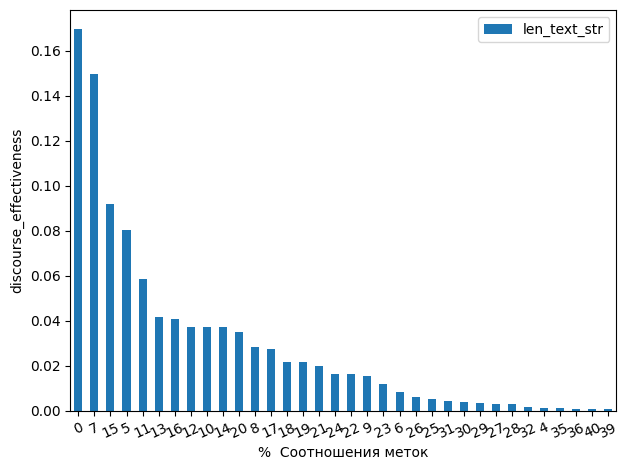

In [25]:
stats_target = train_df['len_text_str'].value_counts(normalize=True)
stats_target=pd.DataFrame(stats_target)
display(stats_target)
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.countplot(data=train_df,y='len_text_str')
plt.subplot(1,2,2)
stats_target.plot.bar(rot=25)
plt.ylabel('discourse_effectiveness')
plt.xlabel('%  Соотношения меток')
plt.tight_layout()
plt.show()

In [26]:
stats_target.head(10)['len_text_str'].sum()

0.7440178074568726

In [27]:
for i in stats_target.index:
    print('________________Образец строки______________________-')
    print('Колличество знаков = ',i, 'процент встречаемости= ',stats_target.loc[[i]].len_text_str*100)
    print(train_df.query('len_text_str==@i').head(1).text_str.values[0])
    print()
    print()
    print()

________________Образец строки______________________-
Колличество знаков =  0 процент встречаемости=  0    16.972732
Name: len_text_str, dtype: float64




________________Образец строки______________________-
Колличество знаков =  7 процент встречаемости=  7    14.969393
Name: len_text_str, dtype: float64
Размер обеспечения исполнения контракта 6593.25 Российский рубль



________________Образец строки______________________-
Колличество знаков =  15 процент встречаемости=  15    9.18197
Name: len_text_str, dtype: float64
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта



________________Образец строки______________________-
Колличество знаков =  5 процент встречаемости=  5    8.013356
Name: len_text_str, dtype: float64
Размер обеспечения исполнения контракта 10.00%



________________Образец строки______________________-
Колличество знаков =  11 процент встречаемости=  11    5.843072
Name: len_text_str, dtype: float64
Об

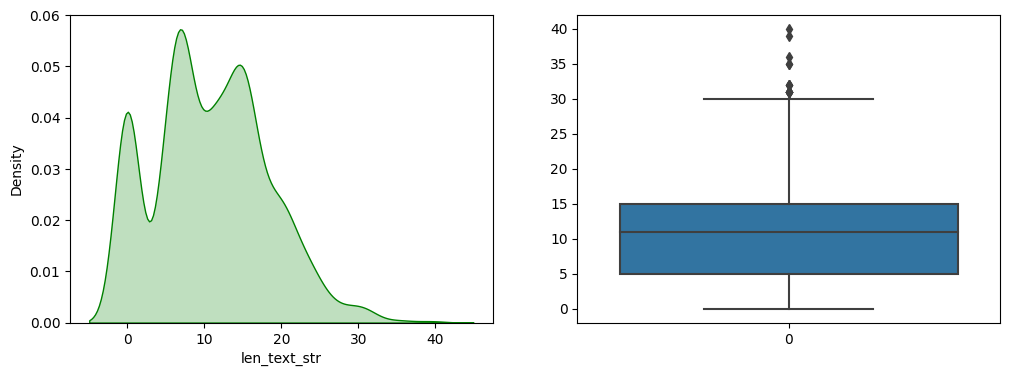

In [28]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.kdeplot(train_df['len_text_str'],color='g',shade=True)
plt.subplot(1,2,2)
sns.boxplot(train_df['len_text_str'])
plt.show()

In [29]:
y_outliers = train_df[abs(zscore(train_df['len_text_str'])) >= 3 ]
y_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 1174 to 1504
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              5 non-null      int64 
 1   text            5 non-null      object
 2   label           5 non-null      object
 3   extracted_part  5 non-null      object
 4   len_text        5 non-null      int64 
 5   text_str        5 non-null      object
 6   text_start      5 non-null      int64 
 7   text_end        5 non-null      int64 
 8   target          5 non-null      int64 
 9   ent             5 non-null      object
 10  pre             5 non-null      int64 
 11  len_text_str    5 non-null      int64 
dtypes: int64(7), object(5)
memory usage: 520.0+ bytes


In [30]:
y_outliers

id  \
1174  792867528   
1386  360876826   
1412  513265910   
1473  127269228   
1504  873845087   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               text  \
1174                    Контракт № ________ на поставку эхолота гидрографического для нужд филиала ФГБУ «Балтийско-Арктическая техмордирекция» Калининградский – г. Калининград г. ____________ «__» __________ 202__ года Федеральное государственное бюджетное учреждение «Балтийско-Арктическая дирекция по  обеспечения может быть уменьшен в порядке и случаях, которые предусмотрены частями 7, 7.1, 7.2 и 7.3 статьи 96 Федерального закона № 44-ФЗ. Действие указанного пункта не распространяется на случаи, если Поставщиком предоставлена недостоверная (поддельная) независимая гарантия. 10.6. Срок возврата Заказчиком Поставщику денежных средств, внесенных в качестве обеспечения исполнения Контракта (если такая форма обеспечения исполнения Контракта применяется Поставщиком), в том числе части этих денежных средств в случае уменьшения размера обеспечения исполнения Контракта в соответствии с частями 7, 7.1, 7.2 статьи 96 Федерального закона № 44-ФЗ: не позднее 15 (пятнадцати) дней с даты исполнения Поставщиком обязательств, предусмотренных Контрактом, на счет, указанный Поставщиком. 10.7. В случае неиспо

# Обнаружены выбросы удалю их из обучающей выборки.

In [31]:
train_df=train_df.query('len_text_str!=35')
train_df=train_df.query('len_text_str!=36')
train_df=train_df.query('len_text_str!=39')
train_df=train_df.query('len_text_str!=40')

# Вывод.
* Данные готовы к исследованию. 
* обнаружены и удалены выбросы в текстах и искомых фрагментах.
* Искомые фрагменты большинство однотипны и могут быть описаны регулярными выражениями или паттернами nlp.
* Accuracy не прибегая к машинному обучению может составлять до 0.74, простым написанием 10 регулрных выражений или паттернов nlp.

# Сформируем валидационную и обучающую выборки.

In [32]:
X = train_df
y = train_df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [33]:
X_train.shape

(1523, 12)

In [34]:
y_train.shape

(1523, 12)

In [35]:
X_test.shape

(269, 12)

In [36]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269 entries, 628 to 297
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              269 non-null    int64 
 1   text            269 non-null    object
 2   label           269 non-null    object
 3   extracted_part  269 non-null    object
 4   len_text        269 non-null    int64 
 5   text_str        269 non-null    object
 6   text_start      269 non-null    int64 
 7   text_end        269 non-null    int64 
 8   target          269 non-null    int64 
 9   ent             269 non-null    object
 10  pre             269 non-null    int64 
 11  len_text_str    269 non-null    int64 
dtypes: int64(7), object(5)
memory usage: 27.3+ KB


In [37]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1792 entries, 0 to 1798
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1792 non-null   int64 
 1   text            1792 non-null   object
 2   label           1792 non-null   object
 3   extracted_part  1792 non-null   object
 4   len_text        1792 non-null   int64 
 5   text_str        1792 non-null   object
 6   text_start      1792 non-null   int64 
 7   text_end        1792 non-null   int64 
 8   target          1792 non-null   int64 
 9   ent             1792 non-null   object
 10  pre             1792 non-null   int64 
 11  len_text_str    1792 non-null   int64 
dtypes: int64(7), object(5)
memory usage: 182.0+ KB


# nlp 

# Сформируем TRAIN_DATA

In [38]:
TRAINING_DATA=[]
for index, row in X_train.iterrows():
    TRAINING_DATA.append((row['text'],{"entities":[(row['text_start'],row['text_end'],row['label'])]}))

In [39]:
TRAINING_DATA[0]

('ПРОЕКТ МУНИЦИПАЛЬНОГО КОНТРАКТА с.Новобелокатай «____» ___________2022 г. Администрация муниципального района Белокатайский район, именуемая в дальнейшем «Заказчик», в лице заместителя главы Администрации по строительству, транспорту, ЖКХ и развитию инфраструктуры Гладышева Константина одрядчик, исполнитель) требование об уплате неустоек (штрафов, пеней). 7.11. Пеня начисляется за каждый день просрочки исполнения поставщиком (подрядчиком, исполнителем) обязательства, предусмотренного контрактом, начиная со дня, следующего после дня истечения установленного контрактом срока исполнения обязательства, и устанавливается контрактом в размере одной трехсотой действующей на дату уплаты пени ключевой ставки Центрального банка Российской Федерации от цены контракта, уменьшенной на сумму, пропорциональную объему обязательств, предусмотренных контрактом и фактически исполненных Поставщиком, за исключением случаев, если законодательством Российской Федерации установлен иной порядок начисления пе

In [40]:
#re.finditer(substr, str1)] 
print(train_df['extracted_part'].head(1).astype( str ))

0    {'text': ['Размер обеспечения исполнения контракта 6593.25 Российский рубль'], 'answer_start': [1279], 'answer_end': [1343]}
Name: extracted_part, dtype: object


# Обучим  модель.

nlp = spacy.blank("ru")
ner = nlp.create_pipe("ner")
nlp.add_pipe(ner)
ner.add_label("обеспечение исполнения контракта")
ner.add_label("обеспечение гарантийных обязательств")
nlp.begin_training()
nlp=spacy.load("model199")

for i in range(200,400):
    random.shuffle(TRAINING_DATA)
    for batch in spacy.util.minibatch(TRAINING_DATA):
        texts = [text for text, annotation in batch]
        annotations = [annotation for text, annotation in batch]
        nlp.update(texts, annotations)
    
        #Валидация 
    for index, row in X_train.iterrows():
        doc = nlp(row['text'])
        if doc.ents:
            X_train['ent'].loc[index]=str(doc.ents[0])
        else:
            X_train['ent'].loc[index]=''
        
        
    for index, row in X_train.iterrows():
        if X_train['ent'].loc[index]==X_train['text_str'].loc[index]:
            X_train['pre'].loc[index]=1
        
    print('Эпоха', i, )
    print('accuracy обучающей выборки', accuracy_score(X_train['target'], X_train['pre']))
    print('-----------------------------------------------------------------------------')
        
        
        
        
    for index, row in X_test.iterrows():
        doc = nlp(row['text'])
        if doc.ents:
            X_test['ent'].loc[index]=str(doc.ents[0])
        else:
            X_test['ent'].loc[index]=''
        
        
    for index, row in X_test.iterrows():
        if X_test['ent'].loc[index]==X_test['text_str'].loc[index]:
            X_test['pre'].loc[index]=1
        
    print('Эпоха', i, )
    print('accuracy вылидационной  выборки', accuracy_score(X_test['target'], X_test['pre']))
    print('-----------------------------------------------------------------------------')
        #Валидация
        
    nlp.to_disk("model"+str(i))

In [41]:
nlp=spacy.load("model307")

In [42]:

doc = nlp(
'''УТВЕРЖДЕНО решением Единой закупочной комиссии ООО «Технический заказчик Фонда развития территорий» Извещение о проведении открытого конкурса в электронной форме и документация о проведении открытого конкурса в электронной форме на выполнение ия участникам закупки документации о закупке – с 02.09.2022 по 21.09.2022 13.6 В случае если запрос на предоставление документации о закупке поступил на почтовый адрес, указанный в пункте 2 настоящего извещения, заказчик, организатор закупки предоставляет документацию о закупке по адресу, указанному в пункте 2 настоящего извещения. 13.7 В случае если запрос на предоставление документации о закупке поступил на адрес электронной почты, указанный в пункте 2 настоящего извещения, заказчик, организатор закупки направляет документацию о закупке на адрес электронной почты, указанный в запросе на предоставление документации о закупке. 13.8 Документация о закупке заинтересованному лицу предоставляется бесплатно. 14. Информация о размере обеспечения заявок на участие в закупке 14.1 Обеспечение заявки – не устанавливается 14.2 Информация о порядке и способе обеспечения заявок на участие в закупке указана в п. 4 документации о закупке. 15. Информация о размере обеспечения исполнения договора 15.1 Обеспечение исполнения договора устанавливается в размере 2% - 43 375 595 (сорок три миллиона триста семьдесят пять тысяч пятьсот девяносто пять) рублей, 65 копеек. 15.2 Информация о порядке и способе обеспечения исполнения договора на участие в закупке указана в п. 5 документации о закупке. 15.3 Размер обеспечения гарантийных обязательств установлен в размере 2% (два процента) от цены договора. 15.4 Порядок и способ предоставления обеспечения гарантийных обязательств указан в п.8.4.1. Проекта договора. 16. Антидемпинговые меры 16.1. Под демпингом понимается предложение цены, сделанное участником закупки, на 25 (двадцать пять) процентов и более ниже начальной (максимальной) цены договора (цены единицы услуги) (далее – Предложение с признаками демпинга), за исключением случаев предоставления участником закупки в составе заявки информации о наличии у него опыта поставки товаров, выполнения работ, оказания услуг по предмету закупки на сумму не менее 50 (пятидесяти) процентов от начальной (максимальной) цены договора/предельной цены договора, устан Руководитель/уполномоченный представитель участника закупки или каждого лица, выступающего на стороне коллективного участника закупки ________________ (Фамилия И.О.) (реквизиты документа, подтверждающего полномочия) (подпись)''')

for ent in doc.ents:
    if ent.label_ == "обеспечение исполнения контракта" and ent.start != 0:
        print(ent.text, ent.label_)



Обеспечение исполнения договора устанавливается в размере 2% - 43 375 595 (сорок обеспечение исполнения контракта


In [43]:
ents = [(e.text, e.label_,) for e in doc.ents]
print(ents)  

[('Обеспечение исполнения договора устанавливается в размере 2% - 43 375 595 (сорок', 'обеспечение исполнения контракта')]


In [44]:
from spacy import displacy
displacy.render(doc, style='ent', jupyter=True)

In [45]:
nlp.get_pipe("ner").labels

('обеспечение гарантийных обязательств', 'обеспечение исполнения контракта')

# Валидация на всей обучающей выборке.

In [46]:
for index, row in train_df.iterrows():
    doc = nlp(row['text'])
    if doc.ents:
        print(doc.ents[0])
        train_df['ent'].loc[index]=str(doc.ents[0])
    else:
        train_df['ent'].loc[index]=''
    

Размер обеспечения исполнения контракта 6593.25 Российский рубль
Поставщик должен предоставить обеспечение исполнения контракта в размере 10 % от цены Контракта.
Размер обеспечения исполнения контракта 10.00%
Размер обеспечения исполнения контракта 10.00%
Размер обеспечения исполнения контракта 10.00%
Размер обеспечения исполнения контракта устанавливается в размере 5 (пять) процентов от цены, по которой заключается контракт и составляет ___
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены

Размер обеспечения исполнения контракта 98606.87 Российский рубль
Обеспечение исполнения Контракта устанавливается в размере 5 процентов от начальной (максимальной) цены контракта.
Размер обеспечения исполнения контракта 1.00%
Обеспечение исполнения Контракта составляет 10% от цены Контракта(цены лота),что составляет_________ (_____
Поставщик при заключении Контракта должен предоставить Заказчику обеспечение исполнения Контракта в размере 5 % от цены
Поставщик при заключении Контракта должен предоставить Заказчику обеспечение исполнения Контракта в размере 10% начальной (максимальной) цены контракта.
Размер обеспечения гарантийных обязательств 1% начальной (максимальной) цены контракта, что составляет 3 150,00 рублей.
Размер обеспечения исполнения контракта составляет 10 (десять) процентов начальной (максимальной) цены контракта: 8 903 рублей
Размер обеспечения исполнения контракта 5.00%
Размер обеспечения исполнения контракта 9523.60 Российский рубль
Размер обеспечения исполнения конт

Размер обеспечения исполнения контракта 5 % начальной (максимальной) цены контракта
Размер обеспечения исполнения Контракта устанавливается в размере 10 % от цены, по которой заключается Контракт и составляет____________ руб. ___ коп. [цифрами и прописью]. (В случае если предложенная Поставщиком цена Контракта снижена на 25% и более по отношению к начальной (максимальной) цене контракта, Поставщик до заключения Контракта предоставляет Заказчику обеспечение исполнения Контракта в соответствии со статьями 37 и 96 Закона о контрактной системе в размере ________(____)
Размер обеспечения исполнения контракта 5.00%
Размер обеспечения исполнения контракта 5% от цены контракта
Размер обеспечения исполнения контракта 5% от цены контракта
Обеспечение исполнения настоящего Контракта установлено в размере 10% от начальной (максимальной) цены контракта
Размер обеспечения исполнения контракта: 5 % от цены контракта.
Обеспечение исполнения настоящего Контракта устанавливается в размере 1 процент от н

Размер обеспечения исполнения Контракта составляет 5% (пять процентов) от цены Контракта, что составляет _____рублей ____копеек
Размер обеспечения исполнения контракта составляет 5% (десять процентов) от цены контракта, что составляет _______ рублей 00
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 3

Обеспечение исполнения настоящего Контракта установлено в размере 5%.
Обеспечение исполнения настоящего Контракта установлено в размере 5%.
Обеспечение исполнения настоящего Контракта установлено в размере 5%.
Обеспечение исполнения настоящего Контракта установлено в размере 5%.
Обеспечение исполнения настоящего Контракта установлено в размере 5%.
Обеспечение исполнения настоящего Контракта установлено в размере 5%.
Обеспечение исполнения настоящего Контракта установлено в размере 5%.
Обеспечение исполнения настоящего Контракта установлено в размере 5%.
Обеспечение исполнения настоящего Контракта установлено в размере 5%.
Обеспечение исполнения настоящего Контракта установлено в размере 5%.
Обеспечение исполнения настоящего Контракта установлено в размере 5%.
Обеспечение исполнения настоящего Контракта установлено в размере 5%.
Обеспечение исполнения настоящего Контракта установлено в размере 5%.
Обеспечение исполнения настоящего Контракта установлено в размере 5%.
Обеспечение исполнен

Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной

Размер обеспечения исполнения Контракта составляет 5 (пять) % от цены Контракта.
Размер обеспечения исполнения контракта 582714.00 Российский рубль
Размер обеспечения исполнения контракта 5.00%
Поставщик при заключении Контракта должен предоставить Заказчику обеспечение исполнения Контракта в размере ____ , что составляет 5 % цены Контракта .
Размер обеспечения исполнения контракта 16.12 Российский рубль
Поставщик внес обеспечение исполнения Контракта в размере __ , что составляет 5 % Цены Контракта в форме безотзывной независимой гарантии
Обеспечение исполнения Контракта устанавливается в размере 0,50% от цены контракта.
Поставщик предоставляет Заказчику обеспечение исполнения контракта в размере 30 % от начальной (максимальной) цены контракта
Поставщик предоставляет Заказчику обеспечение исполнения контракта в размере 30 % от начальной (максимальной) цены контракта
Обеспечение исполнения настоящего Контракта установлено в размере 5% (пяти процентов) начальной (максимальной) цены Конт

Размер обеспечения исполнения Договора составляет 5% от начальной максимальной цены Договора 123 810,00 руб.
Размер обеспечения исполнения договора: 5 % от начальной (максимальной) цены договора
Обеспечение исполнения обязательств по договору: обеспечение исполнения договора в размере не менее 5% от цены договора.
Обеспечение исполнения договора 10% (десять процентов) от начальной (максимальной) цены договора (лота)
не предусмотрено увеличенное от первоначально установленного обеспечения исполнения договора в 1,5 (полтора) раза, но не более 5% (пяти) от начальной (максимальной) цены договора
Обеспечение исполнения договора установлено в размере 5% от начальной (максимальной) цены договора.
Заказчик вправе установить в документации о закупке требование к обеспечению исполнения договора в размере не более 5 (пяти) процентов от начальной (максимальной) цены договора с НДС
Размер обеспечения гарантийных обязательств не может превышать 20% от начальной (максимальной) цены договора (не требу

обеспечение исполнения обязательств по Договору на сумму не менее 20% от стоимости Договора с учетом НДС по форме Приложения №11
обеспечение исполнения обязательств по Договору на сумму не менее 20% от стоимости Договора с учетом НДС по форме Приложения №11
обеспечение исполнения обязательств по Договору на сумму не менее 20% от стоимости Договора с учетом НДС по форме Приложения №11
Размер обеспечения исполнения договора: 5% НМЦД
Размер обеспечения исполнения договора составляет: 30% от начальной (максимальной) цены договора
Размер обеспечения исполнения договора составляет: 30% от начальной (максимальной) цены договора
Размер обеспечения исполнения Договора составляет 5 процентов начальной (максимальной) цены Договора
Размер обеспечения исполнения договора 3% от начальной (максимальной) цены договора
не предусмотрено увеличенное от первоначально установленного обеспечения исполнения договора в 1,5 (полтора) раза, но не более 5% (пяти) от начальной (максимальной) цены договора
Обеспеч

Размер обеспечения исполнения договора составляет 3 (три) процента от начальной максимальной цены договора
Размер обеспечения исполнения Договора составляет 5 % от начальной (максимальной) цены Договора
Поставщик предоставляет обеспечение исполнения Договора в размере 5% от начальной (максимальной) цены договора, что составляет _
Размер такого обеспечения не может превышать 30 (тридцати) процентов начальной (максимальной) цены договора.
Сумма обеспечения исполнения Договора предусмотрена в следующем размере: 30 % от начальной (максимальной) цены Договора
Сумма обеспечения исполнения Договора предусмотрена в следующем размере: 30 % от начальной (максимальной) цены Договора
Обеспечение исполнения договора предусмотрено в размере 5% начальной (максимальной) цены договора
Размер обеспечения исполнения договора устанавливается в размере 5% начальной цены договора.
Обеспечение исполнение договора 5 (пять) процентов от начальной (максимальной) цены договора
Если договором не предусмотрен аван

Размер обеспечения: 10% (Десять процентов) от начальной (максимальной) цены договора
требование об обеспечении исполнения договора в пределах от 5 до 30 процентов начальной (максимальной) цены договора
Размер обеспечения исполнения Договора, условия, порядок и форма внесения обеспечения исполнения Договора 5 % от начальной (максимальной) цены Договора: 12 600 рублей 00 копеек
Размер обеспечения исполнения договора не может составлять более 100 % от НМЦД.
Размер обеспечения исполнения Контракта составляет рублей копеек (5 процентов от цены контракта).
Размер обеспечения исполнения Договора составляет 20 процентов от цены Договора с учетом НДС
Размер обеспечения исполнения Договора составляет 20 процентов от цены Договора с учетом НДС
участник обязан предоставить обеспечение исполнения договора в размере 5 процентов от начальной (максимальной) цены договора (цены лота)
В документации о закупке может быть установлено требование к обеспечению исполнения договора в размере не более 5 (пяти)

Размер обеспечения исполнения договора составляет: 0,50% от начальной (максимальной) цены договора
обеспечение исполнения договора установлено в размере: 0 рублей (не установлено).
предусмотрено увеличенное от первоначально установленного обеспечения исполнения договора в 1,5 (полтора) раза, но не менее 5% (пяти) от начальной (максимальной) цены договора
не предусмотрено увеличенное от первоначально установленного обеспечения исполнения договора в 1,5 (полтора) раза, но не менее 5% (пяти) от НМЦ
Размер обеспечения исполнения Договора установлен заказчиком в размере 5% от начальной- максимальной цены и составляет
Размер обеспечения договора: 5 % от цены договора
Размер обеспечения исполнения договора составляет: 5% от начальной (максимальной) цены договора
Размер обеспечения исполнения договора составляет: __5___% от начальной (максимальной) цены договора
Обеспечение исполнения договора установлено в размере 10% от начальной (максимальной) цена договора
Размер обеспечения исполнения дог

Размер обеспечения: 5 % от начальной (максимальной) цены договора.
Размер обеспечения исполнения договора составляет 5% от начальной (максимальной) цены договора
обеспечение исполнения договора в размере не менее 5% от цены договора
обеспечение исполнения договора в размере не менее 5% от цены договора
обеспечение исполнения договора в размере не менее 5% от цены договора
обеспечение исполнения гарантийных обязательств в размере не менее 0,5 %
обеспечение исполнения договора в размере не менее 5% от цены договора
Размер обеспечения договора 10 % от НМЦ
Если в документации о закупке среди субъектов МСП установлено требование к обеспечению исполнения договора, размер такого обеспечения: а) не может превышать 5 процентов начальной (максимальной) цены договора (цены лота)
При проведении закупок по группе 2 Заказчик имеет право устанавливать обеспечение исполнения договора в размере: 1) не более 5% от начальной (максимальной) цены договора (лота)
Сумма обеспечения исполнения договора: 49 50

Обеспечение гарантийных обязательств предоставляется в размере _____ , что составляет 0.5 % начальной (максимальной) цены контракта, предусмотренной извещением об осуществлении закупки.
Размер обеспечения гарантийных обязательств 115000.00 Российский рубль
Размер обеспечения гарантийных обязательств 39479.62 Российский рубль
Размер обеспечения гарантийных обязательств составляет 1% (Один процент) от цены Контракта, что составляет 22 484 (Двадцать две тысячи четыреста восемьдесят четыре) рубля 30 копеек.
Размер обеспечения гарантийных обязательств 48921.67 Российский рубль
Обеспечение гарантийных обязательств устанавливается в размере в размере 5% от начальной (максимальной) цены
Размер обеспечения гарантийных обязательств составляет 1% начальной (максимальной) цены контракта.
Размер обеспечения гарантийных обязательств составляет 1% начальной (максимальной) цены контракта.
Обеспечение гарантийных обязательств устанавливается в размере 1% от начальной (максимальной) цены контракта.
Разм

Подрядчик обязан предоставить Заказчику обеспечение гарантийных обязательств в размере 1.00 % от начальной (максимальной) цены контракта, что составляет 47934.00 руб.
Обеспечение гарантийных обязательств установлено в размере 1% начальной (максимальной) цены контракта и составляет 11600,00 руб.
Размер обеспечения гарантийных обязательств 217204.44 Российский рубль
Размер обеспечения гарантийных обязательств составляет 3% 570 (пятьсот семьдесят) рублей 00 копеек.
Размер обеспечения гарантийных обязательств: 0,00 рублей.
Размер обеспечения гарантийных обязательств, порядок предоставления такого обеспечения, требования к такому обеспечению 2% от НМЦК – 120 880,00 рублей
Размер обеспечения исполнения контракта 10.00%
Размер обеспечения гарантийных обязательств 710501.82 Российский рубль
Размер обеспечения гарантийных обязательств не установлен.
Размер обеспечения исполнения контракта 5.00%
Размер обеспечения гарантийных обязательств: 0,00 рублей. Доля: 0,00 % от начальной (максимальной) це

Размер обеспечения гарантийных обязательств составляет: 0,00 % от начальной (максимальной) цены контракта, что составляет 0,00 рублей.
Обеспечение гарантийных обязательств устанавливается в размере 1% от начальной (максимальной) цены Контракта.
Размер обеспечения исполнения контракта 30.00%
Обеспечение гарантийных обязательств предоставляется Поставщиком Заказчику не позднее даты
Размер обеспечения гарантийных обязательств составляет 30437 (тридцать тысяч четыреста тридцать семь) рублей 84 копейки (1 процент начальной (максимальной) цены Контракта).
Размер обеспечения гарантийных обязательств составляет 5 процентов начальной (максимальной) цены контракта, что составляет 307 676
Размер обеспечения гарантийных обязательств 49990.00 Российский рубль
Размер обеспечения гарантийных обязательств 12366.84 Российский рубль
Размер обеспечения гарантийных обязательств 82492.75 Российский рубль
Размер обеспечения гарантийных обязательств установлен в размере 10 % от НМЦК и составляет 8 916,12 (во

Размер обеспечения гарантийных обязательств 44776.67 Российский рубль
Размер обеспечения гарантийных обязательств 175630.00 Российский рубль
Размер обеспечения гарантийных обязательств 1350122.66 Российский рубль
Размер обеспечения гарантийных обязательств 34328,21 руб. руб., что составляет 5 процентов от начальной (максимальной) цены контракта.
Размер обеспечения гарантийных обязательств 112364.19 Российский рубль
Размер обеспечения гарантийных обязательств – 5 % начальной (максимальной) цены контракта, что составляет 172149,85 рублей
Поставщик при поставке товара одновременно предоставляет Заказчику обеспечение гарантийных обязательств в размере 1% от начальной (максимальной) цены контракта – _____ рублей.
Размер обеспечения гарантийных обязательств: 5 % (пять процентов) начальной (максимальной) цены Контракта, что составляет 19 934
Размер обеспечения гарантийных обязательств составляет 5 % от начальной (максимальной) цены Контракта, что составляет __________________ (_______________

Обеспечение гарантийных обязательств предоставляется в размере _____ , что составляет 0.5 % начальной (максимальной) цены контракта, предусмотренной извещением об осуществлении закупки.
Размер обеспечения гарантийных обязательств 938.66 Российский рубль
Размер обеспечения гарантийных обязательств 55550.00 Российский рубль
Размер обеспечения гарантийных обязательств 3091.24 Российский рубль
Обеспечение гарантийных обязательств устанавливается в размере 0,5 % начальной (максимальной) цены контракта, что составляет ___________ руб.
Размер обеспечения гарантийных обязательств составляет: 0,00 % от начальной (максимальной) цены контракта, что составляет 0,00 рублей.
«Поставщик» обязан предоставить при сдаче-приемке остановочных павильонов обеспечение гарантийных обязательств по настоящему контракту в размере 1 % от начальной максимальной цены контракта, что составляет 6 976
Размер обеспечения гарантийных обязательств 1597.60 Российский рубль
Размер обеспечения гарантийных обязательств 32663

на протяжении указанного в Контракте гарантийного срока, устанавливается обеспечение гарантийных обязательств в размере 1% начальной (максимальной) цены Контракта, что составляет 2165.85 рублей.
Размер обеспечения гарантийных 2 % от начальной (максимальной) цены обязательств контракта – 7 455
Обеспечение гарантийных обязательств по контракту представляется в размере 10 % от начальной (максимальной) цены контракта, что составляет 158 897
Размер обеспечения гарантийных обязательств 94518.00 Российский рубль
Обеспечение гарантийных обязательств установлено в размере 1% от начальной (максимальной) цены контракта и составляет 5 316,20
Размер обеспечения исполнения контракта (договора) составляет: 5,00% от цены, по которой в соответствии с Законом № 44-ФЗ заключается контракт. Размер обеспечения гарантийных обязательств составляет
Размер обеспечения гарантийных обязательств на поставленные товары составляет 10% (десять) процентов от начальной (максимальной) цены, а именно: 876 750,50 руб.
Ра

Размер обеспечения исполнения гарантийных обязательств не может превышать 2 % начальной (максимальной) цены договора (цены лота) и устанавливается в Специальной части.
Подрядчик обязан предоставить Заказчику обеспечение гарантийных обязательств на сумму ________ руб. (_______________ рублей __ копеек), что составляет 0,1% от цены Договора, в форме _____________ (независимой гарантии или путем внесения денежных средств
Требование об обеспечении исполнения гарантийных обязательств 5% от стоимости выполненных Работ
Обеспечение гарантийных обязательств установлено в размере 2% начальной (максимальной) цены договора и составляет – 547 909.00
Заказчиком установлено требование обеспечения исполнения договора и (или) обеспечения исполнения гарантийных обязательств 5%, 132 589,74 (Сто тридцать две тысячи пятьсот восемьдесят девять рублей 74 копеек) рублей.
Размер обеспечения гарантийных обязательств: установлен. Размер обеспечения гарантийных обязательств составляет 1% от цены Договора.
Размер 

Заказчиком установлено требование обеспечения исполнения договора и (или) обеспечения исполнения гарантийных обязательств. 5% от начальной (максимальной) цены договора, что составляет 27450


In [47]:
for index, row in train_df.iterrows():
        if train_df['ent'].loc[index]==train_df['text_str'].loc[index]:
            train_df['pre'].loc[index]=1
            
    
    

In [48]:

accuracy_score(train_df['target'], train_df['pre'])

0.9168526785714286

In [49]:
train_df.query('pre==0')[['text_str','ent']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 23 to 1786
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text_str  149 non-null    object
 1   ent       149 non-null    object
dtypes: object(2)
memory usage: 3.5+ KB


# Выбор оптимальной модели!

In [50]:
for i in range(307,308):
    nlp=spacy.load("model"+str(i))
    for index, row in train_df.iterrows():
        doc = nlp(row['text'])
        if doc.ents:
            train_df['ent'].loc[index]=str(doc.ents[0])
        else:
            train_df['ent'].loc[index]=''
    
    for index, row in train_df.iterrows():
        if train_df['ent'].loc[index]==train_df['text_str'].loc[index]:
            train_df['pre'].loc[index]=1
    print('Номер модели',i,'Точность',accuracy_score(train_df['target'], train_df['pre']))        

Номер модели 307 Точность 0.9168526785714286


# Генерация ответа

In [51]:
test_df = pd.read_json('dataset/test.json', orient='records')
test_df['ent']=''
test_df['answer_start']=0
test_df['answer_end']=0

In [52]:
test_df

id  \
0    762883279   
1    311837655   
2    540954893   
3    274660397   
4    732742591   
..         ...   
313  854936033   
314  576390745   
315  323745820   
316  712286194   
317  880582082   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  text  \
0    МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание услуг по техническому обслуживанию и ремонту принтеров и многофункциональных устройств, заправке и восстановлению картриджей (идентификационный код закупки 223861800296886010100100590019511244) г. Ханты-Мансийск «___» ____________ 2022 г.  (или) возмещения убытков причинённых Исполнителем убытков. 6. Обеспечение исполнения контракта 6.1. Исполнение контракта обеспечиваются предоставлением независимой гарантии, выданной банком и соответствующей требованиям Федерального закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд», или внесением денежных средств на указанный заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими заказчику. Способ обеспечения исполнения контракта, срок действия независимой гарантии определяются в соответствии с требованиями Федерального закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд

In [53]:
for index, row in test_df.iterrows():
    doc = nlp(row['text'])
    if doc.ents:
        print(doc.ents[0])
        test_df['ent'].loc[index]=str(doc.ents[0])
        
        result = test_df['text'].loc[index].rfind(test_df['ent'].loc[index])
        print(result)
        test_df['answer_start'].loc[index]=result
        test_df['answer_end'].loc[index]=result+len(doc.ents[0])
        
        
    else:
        test_df['ent'].loc[index]=''

Размер обеспечения исполнения Контракта составляет _______ рублей ____ копеек (5 процентов от цены контракта).
1283
Размер обеспечения исполнения контракта 10.00%
1291
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
1300
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
1312
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
1314
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
1304
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
1315
Размер обеспечения исполнения контракта 10557.05 Российский рубль
1312
Размер обеспечения исполнения контракта 106489.11 Российский рубль
1291
Размер обеспечения исполнения контракта 33059.00 Российский рубль
1295
Обеспечение исполнения насто

Размер обеспечения исполнения контракта 5.00%
1289
Размер обеспечения исполнения контракта 5.00%
1281
Обеспечение исполнения Договора устанавливается в размере 0% от НМЦД
1261
Размер обеспечения исполнения договора: 5% от начальной (максимальной) цены договора
1141
Размер обеспечения гарантийных обязательств не может превышать десять процентов от начальной (максимальной) цены контракта, от цены контракта, заключаемого с единственным поставщиком (подрядчиком, исполнителем). (п. 2.2 ст. 96 Закона N 44-ФЗ). Исполнение контракта, гарантийные обязательства могут обеспечиваться предоставлением независимой гарантии, соответствующей требованиям статьи 45 Закона № 44-ФЗ, или внесением денежных средств на указанный заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими заказчику. Способ обеспечения исполнения контракта, гарантийных обязательств, срок действия независимой гарантии При этом срок подачи заявок на участие 

Обеспечение исполнения договора установлено в размере 10% начальной (максимальной) цены договора
1272
Обеспечение исполнения настоящего договора предоставляется поставщиком в размере: 3% начальной (максимальной) цены договора на сумму 7 724,00 рублей.
1275
Размер обеспечения гарантийных обязательств не может превышать 10 процентов НМЦД. Обеспечение исполнения гарантийных обязательств может быть предоставлено поставщиком
1243
Размер обеспечения исполнения договора: 5% от начальной (максимальной) цены договора
1226
Размер обеспечения исполнения договора составляет 3 %
1277
Сумма обеспечения исполнения) составляет _____________ (___________ ) рублей
1231
Размер обеспечения исполнения договора: 5% от начальной (максимальной) цены договора
1246
Обеспечение исполнения договора предусмотрено в размере 5% от начальной (максимальной) цены договора
1132
предусмотрено увеличенное от первоначально установленного обеспечения исполнения договора в 1,5 (полтора) раза, но не менее 5% (пяти) от начальн

Предоставление Подрядчиком обеспечения гарантийных обязательств в размере 5 % от начальной (максимальной) цены Договора, что составляет что составляет
1055
Подрядчик обязан предоставить Заказчику обеспечение гарантийных обязательств на сумму ________ руб. (_______________ рублей __ копеек), что составляет 3 % от цены Договора, в форме _____________ (банковской гарантии или путем внесения денежных средств
1218
согласно п. 3.1. Договора Подрядчик представляет Заказчику обеспечение гарантийных обязательств на выполненные работы. Размер обеспечения гарантийных обязательств: 1% от начальной (максимальной) цены контракта (договора), что составляет 24 992,34 рублей (двадцать четыре тысячи девятьсот девяносто два рубля 34 копейки).
1323
Заказчиком установлено требование обеспечения исполнения договора и (или) обеспечения исполнения гарантийных обязательств. Обеспечение исполнения Договора устанавливается в размере 30 процентов начальной (максимальной) цены договора.
1249
Обеспечение исполнения

In [72]:
test_df.head(318)

id  \
0    762883279   
1    311837655   
2    540954893   
3    274660397   
4    732742591   
5    102997495   
6    355078344   
7    803828087   
8    285525147   
9    321195392   
10   239515086   
11   721670436   
12   397624936   
13   359504693   
14   156657019   
15   595792103   
16   797177608   
17   472554208   
18   766676403   
19   265592883   
20   754797829   
21   354081808   
22   247749116   
23   147306439   
24   116946900   
25   268847966   
26   285356279   
27   895392101   
28   479087418   
29    83305216   
30   334634031   
31   106053303   
32    85538637   
33   225361701   
34   153633237   
35   521357454   
36   807093000   
37   823797961   
38   319448049   
39    67882218   
40   171827480   
41   799481025   
42   307185937   
43    20270315   
44   251568076   
45   435348470   
46   917264808   
47   781467981   
48   794555041   
49   283608410   
50   249355421   
51   674137351   
52    10334909   
53   475875602   
54   356237909   
55   922222619   
56   740607433   
57   493020520   
58   711283953   
59   861933225   
60   921302318   
61   247865534   
62   197972046   
63   759076954   
64   308749124   
65   916518814   
66   501899873   
67   636547637   
68   471276173   
69   866656305   
70   793730044   
71   388082324   
72   627025132   
73   541533369   
74    69711096   
75   559981897   
76   980198186   
77   950774966   
78   456989800   
79   797778865   
80   810144332   
81   673739346   
82   274243050   
83   983557564   
84   745519670   
85    72963552   
86   459769287   
87   679367698   
88   520580304   
89   594417067   
90    85014344   
91   994630880   
92   269002425   
93   259421037   
94   994372174   
95   408666530   
96   524421900   
97   417360348   
98    22224195   
99   967373573   
100  297909206   
101  653080860   
102  802445768   
103  134892680   
104  568706663   
105  459491171   
106  548944780   
107  386049175   
108  859358972   
109  755592970   
110  483855380   
111  664351842   
112  111634389   
113  808673569   
114  679448298   
115  830642737   
116  286691132   
117   98709131   
118  580822333   
119  639686020   
120  734127970   
121  854743708   
122  827678792   
123  977181742   
124  772606250   
125  395996287   
126   89355072   
127  655263309   
128  979302601   
129  668202048   
130  696662443   
131  524454208   
132  568517082   
133  872741092   
134  162782689   
135  438135946   
136  181449810   
137  957290442   
138  145203689   
139  917657292   
140  294198487   
141  352262868   
142  867693606   
143  114493241   
144  903385610   
145  406364475   
146  168746962   
147  462615386   
148  518487386   
149  250239535   
150  847607204   
151  854819288   
152  196530783   
153  331278975   
154  227079396   
155  440980527   
156  471368248   
157  838064792   
158  710868235   
159  831748856   
160  646135416   
161  753461401   
162  600780432   
163  743505277   
164  326205870   
165  592038157   
166  402500216   
167  295822103   
168  656383963   
169  466349093   
170  821477904   
171  453896166   
172  354119687   
173  536283579   
174  466698040   
175  280434847   
176  467671960   
177  134173603   
178  967546466   
179   97094066   
180  938996409   
181  838485341   
182  449117720   
183  258409202   
184  655426252   
185  521747378   
186  428391250   
187  954745507   
188  774839918   
189  647279640   
190  180399775   
191  492778731   
192  763836375   
193  576652599   
194  486915187   
195  860875902   
196  286466221   
197  295687391   
198  707135889   
199  608877223   
200  740388056   
201  227478271   
202   61431769   
203  973653290   
204   16776716   
205  698041366   
206  353934093   
207   55543088   
208  807171584   
209  733564105   
210  108391202   
211  738900998   
212  619138978   
213  161078204   
214  143304006   
215  856352622   
216  559942465   
217  395873520   
218  263709077   
219  193197344   
220  834851261   
221  430216673  

In [55]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            318 non-null    int64 
 1   text          318 non-null    object
 2   label         318 non-null    object
 3   ent           318 non-null    object
 4   answer_start  318 non-null    int64 
 5   answer_end    318 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 15.0+ KB


In [56]:
predictions=[]
for index, row in test_df.iterrows():
    predictions.append({
    "id": row['id'],
    "text":row['text'],
    "label": row['label'],
    "extracted_part": {
      "text": [
        row['ent']
      ],
      "answer_start": [
        row['answer_start']
      ],
      "answer_end": [
        row['answer_end']
      ]
    }
  })
    

In [57]:
predictions[0]

{'id': 762883279,
 'text': 'МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание услуг по техническому обслуживанию и ремонту принтеров и многофункциональных устройств, заправке и восстановлению картриджей (идентификационный код закупки 223861800296886010100100590019511244) г. Ханты-Мансийск «___» ____________ 2022 г.  (или) возмещения убытков причинённых Исполнителем убытков. 6. Обеспечение исполнения контракта 6.1. Исполнение контракта обеспечиваются предоставлением независимой гарантии, выданной банком и соответствующей требованиям Федерального закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд», или внесением денежных средств на указанный заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими заказчику. Способ обеспечения исполнения контракта, срок действия независимой гарантии определяются в соответствии с требованиями Фед

In [58]:
i={
    "id": 809436509,
    "text": "Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты счета в соответствии с п.16 ч. 1 ст. 42 Закона № 44-ФЗ \"Номер расчётного счёта\" 00000000000000000000 \"Номер лицевого счёта\" См. прилагаемые документы \"БИК\" 000000000 \"Наименование кредитной организации\" \"Номер корреспондентского счета\" Обеспечение исполнения контракта Требуется обеспечение исполнения контракта Размер обеспечения исполнения контракта 6593.25 Российский рубль Порядок обеспечения исполнения контракта, требования к обеспечению Исполнение контракта, гарантийные обязательства могут обеспечиваться предоставлением независимой гарантии, соответствующей требованиям ст. 45 Федерального закона № 44-ФЗ, или внесением денежных средств на указанный заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими заказчику. Способ обеспечения исполнения контракта, гарантийных обязательств, срок действия независимой гарантии определяются в соответствии с требованиями Федерального закона № 44-ФЗ участником закупки, с которым заключается контракт, самостоятельно. При этом срок действия независимой гарантии должен превышать предусмотренный контрактом срок исполнения обязательств, которые должны быть обеспечены такой независимой гарантией, не менее чем на один месяц, в том числе в случае его изменения в соответствии со ст. 95 Федерального закона № 44-ФЗ. Порядок предоставления и требования о Информация и документы, подтверждающие соответствие участников закупки дополнительным требованиям: 1) исполненный договор; 2) акт приемки оказанных услуг и (или) поставленных товаров, подтверждающий цену оказанных услуг и (или) поставленных товаров 4",
    "label": "обеспечение исполнения контракта",
    "extracted_part": {
      "text": [
        "Размер обеспечения исполнения контракта 6593.25 Российский рубль"
      ],
      "answer_start": [
        1279
      ],
      "answer_end": [
        1343
      ]
    }
  },

In [59]:
i[0]

{'id': 809436509,
 'text': 'Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты счета

In [60]:
import json
with open('predictions.json', 'w', encoding='utf-8') as f:
    json.dump(predictions, f, ensure_ascii=False, indent=4)

## Проверка типов данных в ответе!

In [61]:
def check_valid_JSOn(filename):
    try:
        with open(filename) as file:
         parse_json = json.load(file)
         #print(parse_json) 
         return True
    except ValueError as e:        
        return False
 
print('Валидность :',check_valid_JSOn('dataset/train.json'))
print('валидность :',check_valid_JSOn('predictions.json'))


Валидность : True
валидность : True


In [62]:
f = open('dataset/train.json')
data_train = json.load(f)
f.close()
print(data_train[0])  # or `print data['two']` in Python 2

{'id': 809436509, 'text': 'Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты счета 

In [63]:
print(type(data_train[0]['id']))
print(type(data_train[0]['text']))
print(type(data_train[0]['label']))
print(type(data_train[0]['extracted_part']['text']))
print(type(data_train[0]['extracted_part']['answer_start']))
print(type(data_train[0]['extracted_part']['answer_end']))
print(type(data_train[0]['extracted_part']['text'][0]))
print(type(data_train[0]['extracted_part']['answer_start'][0]))
print(type(data_train[0]['extracted_part']['answer_end'][0]))

<class 'int'>
<class 'str'>
<class 'str'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'str'>
<class 'int'>
<class 'int'>


In [64]:
f = open('predictions.json')
data_test = json.load(f)
f.close()
print(data_test[0]) 

{'id': 762883279, 'text': 'МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание услуг по техническому обслуживанию и ремонту принтеров и многофункциональных устройств, заправке и восстановлению картриджей (идентификационный код закупки 223861800296886010100100590019511244) г. Ханты-Мансийск «___» ____________ 2022 г.  (или) возмещения убытков причинённых Исполнителем убытков. 6. Обеспечение исполнения контракта 6.1. Исполнение контракта обеспечиваются предоставлением независимой гарантии, выданной банком и соответствующей требованиям Федерального закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд», или внесением денежных средств на указанный заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими заказчику. Способ обеспечения исполнения контракта, срок действия независимой гарантии определяются в соответствии с требованиями Феде

In [65]:
print(type(data_test[0]['id']))
print(type(data_test[0]['text']))
print(type(data_test[0]['label']))
print(type(data_test[0]['extracted_part']['text']))
print(type(data_test[0]['extracted_part']['answer_start']))
print(type(data_test[0]['extracted_part']['answer_end']))
print(type(data_test[0]['extracted_part']['text'][0]))
print(type(data_test[0]['extracted_part']['answer_start'][0]))
print(type(data_test[0]['extracted_part']['answer_end'][0]))

<class 'int'>
<class 'str'>
<class 'str'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'str'>
<class 'int'>
<class 'int'>


### Вывод json валиден, типы данных совпадают

# EDA реузультатов прогнозирования

len_text_str
0        0.264151
7        0.150943
15       0.106918
5        0.094340
14       0.037736
12       0.037736
11       0.034591
20       0.031447
13       0.028302
18       0.025157
8        0.022013
16       0.022013
10       0.022013
9        0.018868
17       0.012579
23       0.012579
21       0.012579
19       0.009434
26       0.009434
22       0.009434
32       0.006289
6        0.006289
48       0.003145
53       0.003145
100      0.003145
27       0.003145
178      0.003145
108      0.003145
38       0.003145
24       0.003145

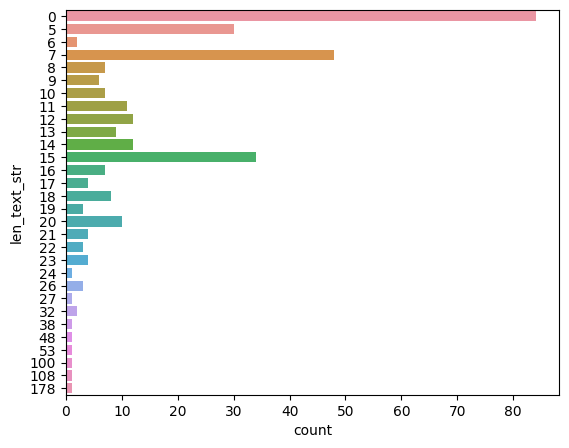

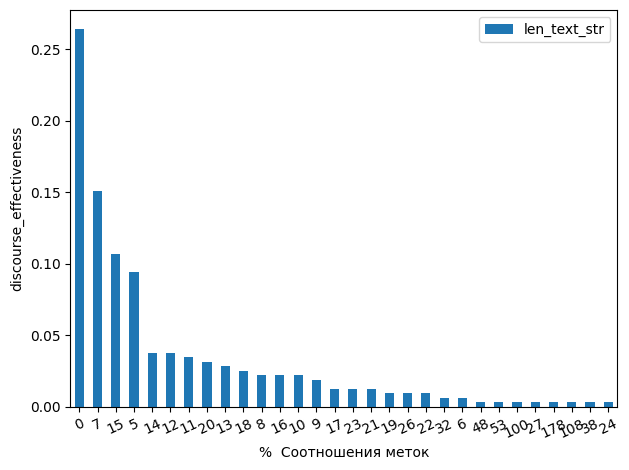

In [75]:
test_df['len_text_str'] = test_df['ent'].apply(length_text)
stats_target = test_df['len_text_str'].value_counts(normalize=True)
stats_target=pd.DataFrame(stats_target)
display(stats_target)
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.countplot(data=test_df,y='len_text_str')
stats_target.plot.bar(rot=25)
plt.ylabel('discourse_effectiveness')
plt.xlabel('%  Соотношения меток')
plt.tight_layout()
plt.show()

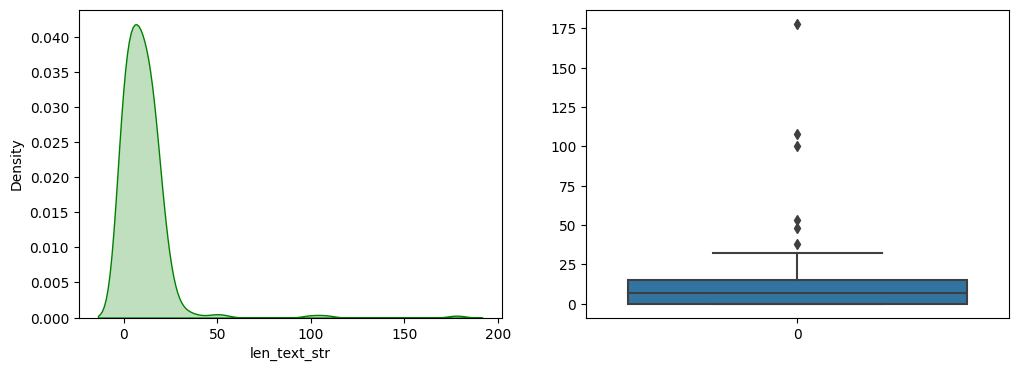

In [67]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.kdeplot(test_df['len_text_str'],color='g',shade=True)
plt.subplot(1,2,2)
sns.boxplot(test_df['len_text_str'])
plt.show()